#  第五讲 无标度网络【实践】一

In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# Author ： 单哥的科研日常
# 关注B站和公众号：单哥的科研日常，获取更多讲解教程

### 实验环境：
### Python版本==3.9.6, networkx==2.6.3, matplotlib==3.5.2, numpy==1.23.1, pandas==1.4.3, scipy==1.9.0

## 1、道路网络和航空网络的度分布

In [1]:
# 导入库
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# 加载euroroad数据集（欧洲道路网络数据）
df1 = pd.read_csv("euroroad.csv")  # 从CSV文件读取欧洲道路网络的边数据
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', create_using = nx.Graph())  # 根据边列表创建无向图对象，source和target是起点和终点列

# 加载openflights数据集（航班飞行网络数据）
df2 = pd.read_csv("openflights.csv")  # 从CSV文件读取航空飞行网络的边数据
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', create_using = nx.Graph())  # 根据边列表创建无向图对象，source和target是起点和终点列

# 输出两个网络的节点数量
print(len(G1.nodes()), len(G2.nodes()))  # 分别打印欧洲道路网络和航空飞行网络的节点数量

1174 3425


In [3]:
# 定义求度分布的函数
def get_pdf(G):
    all_k = [G.degree(i) for i in G.nodes()]
    k = list(set(all_k))  # 获取所有可能的度值
    N = len(G.nodes())
    
    Pk = []
    for ki in sorted(k):
        c = 0
        for i in G.nodes():
            if G.degree(i) == ki:  
                c += 1  
        Pk.append(c/N)     
    
    return sorted(k), Pk

In [4]:
deg1 = [G1.degree(i) for i in G1.nodes()]
deg2 = [G2.degree(i) for i in G2.nodes()]
k1, Pk1 = get_pdf(G1)
k2, Pk2 = get_pdf(G2)

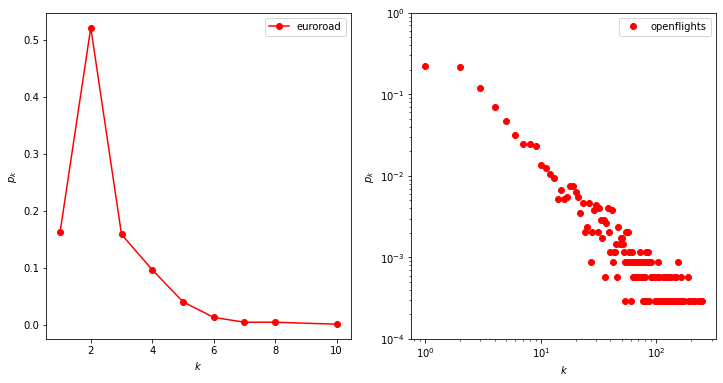

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(k1, Pk1, 'ro-', label='euroroad')
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")

plt.subplot(122)
plt.plot(k2, Pk2, 'ro', label='openflights')
plt.legend(loc=0)
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.ylim([1e-4,1])
plt.xscale("log")
plt.yscale("log")

## 2、对于航空网络，粗略拟合度分布

In [6]:
from scipy import optimize

In [7]:
def fit_line(x, a, b):
    return a * x + b

斜率 a =  -1.366312420298909


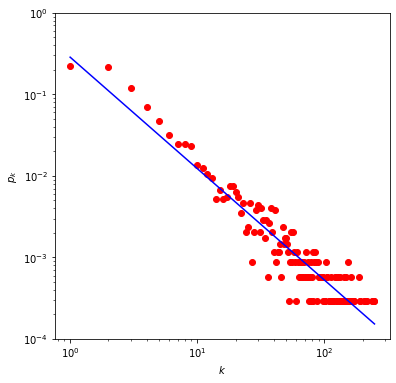

In [ ]:
x = np.log10(np.array(k2))  # 对度k2取对数，转换为x轴坐标
y = np.log10(np.array(Pk2))  # 对度分布概率Pk2取对数，转换为y轴坐标

kmin2, kmax2 = min(deg2), max(deg2)  # 获取度的最小值和最大值
# 使用curve_fit函数拟合幂律分布，fit_line是前面定义的线性函数
a, b = optimize.curve_fit(fit_line, x, y)[0]  # 获取拟合参数a和b，a为斜率
print("斜率 a = ", a)  # 打印拟合的斜率，斜率a代表幂律分布的指数γ (实际上γ = -a)

x1 = np.arange(kmin2, kmax2, 0.01)  # 创建用于绘图的x轴数据点，从最小度到最大度
y1 = (10**b) * (x1 ** a)  # 计算拟合曲线的y值，公式为y = 10^b * x^a

plt.figure(figsize=(6,6))  # 创建6x6大小的图形
plt.plot(k2, Pk2, 'ro')  # 绘制原始数据点，红色圆点
plt.plot(x1, y1, 'b-')  # 绘制拟合曲线，蓝色实线
plt.xlabel("$k$")  # 设置x轴标签为k
plt.ylabel("$p_k$")  # 设置y轴标签为p_k
plt.ylim([1e-4,1])  # 设置y轴范围从10^-4到1
plt.xscale("log")  # 将x轴设置为对数刻度
plt.yscale("log")  # 将y轴设置为对数刻度

In [9]:
import powerlaw
# 安装：pip install powerlaw

In [10]:
data = [G2.degree(i) for i in G2.nodes()]
print(max(data))

fit = powerlaw.Fit(data)
print(fit)
kmin = fit.power_law.xmin
print("kmin:", kmin)
print("gamma:", fit.power_law.alpha)
print("D:", fit.power_law.D)

248
Calculating best minimal value for power law fit
kmin: 2.0
gamma: 1.9028919860606162
D: 0.05721869113396072


<AxesSubplot:>

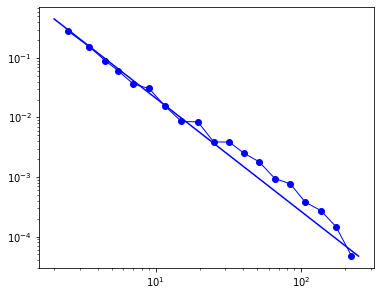

In [11]:
plt.figure(figsize=[6, 4.8])
fig = fit.plot_pdf(marker = 'o', color='b', linewidth=1)
fit.power_law.plot_pdf(color='b', linestyle='-', ax=fig)

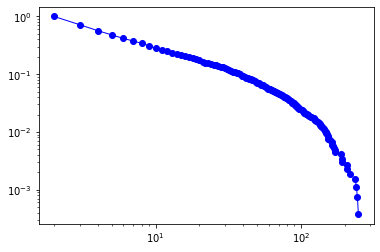

In [12]:
fig = fit.plot_ccdf(marker = 'o', color='b', linewidth=1)

## 3、生成符合幂律分布的度序列

In [13]:
from networkx.utils import powerlaw_sequence

In [ ]:
# 使用powerlaw_sequence函数生成符合幂律分布的序列
# 参数说明：10000表示生成序列的长度，exponent=2.5表示幂律分布的指数γ
degree_seq = powerlaw_sequence(10000, exponent=2.5)

# 将生成的浮点数度值转换为整数，因为实际网络中的度都是整数
int_deg = [int(di) for di in degree_seq]

# 注释掉打印语句，避免输出过多数据
# print(int_deg)

In [15]:
fit = powerlaw.Fit(int_deg)
print(fit)
kmin = fit.power_law.xmin
print("kmin:", kmin)
print("gamma:", fit.power_law.alpha)
print("D:", fit.power_law.D)

Calculating best minimal value for power law fit
kmin: 5.0
gamma: 2.6402617728964013
D: 0.04479316336979211


<AxesSubplot:>

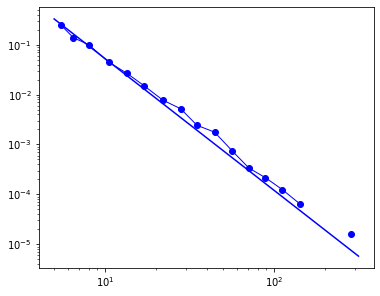

In [16]:
plt.figure(figsize=[6, 4.8])
fig = fit.plot_pdf(marker = 'o', color='b', linewidth=1)
fit.power_law.plot_pdf(color='b', linestyle='-', ax=fig)